# Práctica: Análisis estadístico de la regla de cinco de Lipinski

## Teoría

### **Huellas dactilares moleculares**
Las huellas dactilares moleculares son herramientas quimioinformáticas esenciales para el cribado virtual y el mapeo del espacio químico. Esta es una forma de describir una estructura molecular que puede convertir una estructura molecular en una cadena de bits ([Seo, Shin, Myung, Hwang & No, 2020](https://doi.org/10.1186/s13321-020-0410- 3)). Cada bit corresponde a una característica o entorno molecular predefinido, donde "1" representa la presencia y "0" la ausencia de una característica. Dado que la huella digital molecular codifica la estructura de una molécula, es un método útil para describir la similitud estructural entre las moléculas como un descriptor molecular.

#### **Huellas dactilares de Morgan**
La huella digital molecular más popular es la huella dactilar de Morgan que se basa en el algoritmo de Morgan. Estos bits generados por algoritmos corresponden a los entornos circulares de cada átomo en una molécula y el número de enlaces y átomos vecinos a considerar está establecido por el radio, que son predictivos de las actividades biológicas de las moléculas orgánicas pequeñas ([Capecchi, Probst & Reymond, 2020](https://doi.org/10.1186/s13321-020-00445-4)).

### **Medida de similitud molecular: coeficiente de Tanimoto**
Dos de estas huellas dactilares se comparan más comúnmente con la métrica de similitud de Tanimoto. Estas métricas toman un valor entre 0 y 1, correspondiendo 1 a huellas dactilares idénticas ([Rácz, Bajusz & Héberger, 2018](https://doi.org/10.1186/s13321-018-0302-y))


![Coeficiente-Tanimoto](data/Tanimoto-coefficient.jpg)

### **Agrupación**
Es la tarea de agrupar un conjunto de objetos de tal manera que los objetos del mismo grupo (llamado clúster) sean más similares entre sí que a los de otros grupos (clusters). La agrupación de compuestos en la investigación farmacéutica a menudo se basa en la similitud química o estructural entre compuestos para encontrar grupos que comparten propiedades.

Hay [pasos clave] (https://www.sciencedirect.com/science/article/pii/B008045044X001474) en el enfoque de agrupación que seguiremos:

**1. Preparación de datos y codificación compuesta:**

- Los compuestos en los datos de entrada se codificarán como huellas dactilares moleculares.
    
**2. Matriz de similitud (o distancia) de Tanimoto:**

- La similitud entre dos huellas dactilares se calcula mediante el coeficiente de Tanimoto.
- Matriz con similitudes de Tanimoto entre todos los posibles pares de moléculas/huellas dactilares (matriz de similitud n * n con = número de moléculas, solo se usa la matriz del triángulo superior).
- Igualmente, se puede calcular la matriz de distancias (1 - semejanza).
    
**3. Agrupación de moléculas**

- El resultado de la agrupación depende del umbral elegido por el usuario:
    - Cuanto menor sea el valor de corte de la distancia, más similares se requieren los compuestos para pertenecer a un grupo.
    - Cuanto mayor sea el umbral (corte de distancia), más moléculas se considerarán similares, tendrá menos grupos.
    - Cuanto más bajo es el umbral, más pequeños grupos y "singletons" aparecen.

## Planteamiento del problema
Tenemos un conjunto de datos con muchos compuestos y queremos agruparlos porque compuestos similares pueden unirse a los mismos objetivos y mostrar efectos similares. A partir de dicha agrupación, también se puede seleccionar un conjunto diverso de compuestos de un conjunto más grande de compuestos de detección para realizar más pruebas experimentales.

In [1]:
# Importar las librerias necesarias
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from rdkit import Chem, DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import (
    PandasTools,
    Draw,
    rdFingerprintGenerator,
)

# Ejemplo 1: Comparar una molécola con un conjunto de datos

Inicialmente, queremos comparar una molécula de consulta con todas las moléculas del conjunto de datos que contiene los compuestos bioactivos contra la *glucógeno sintasa quinasa-3 beta*. En este caso la molécula de consulta es **Ruboxistaurin**, queremos buscar moléculas similares.

## Paso 1: Cargar conjunto de datos
El conjunto de datos que contiene los compuestos bioactivos contra la *glucógeno sintasa quinasa-3 beta* lo construimos en el tutorial 2.1_Dataframes.

In [2]:
molecule_dataset = pd.read_csv("data/compounds_P49841_full.csv", usecols=["molecule_chembl_id", "smiles"])
print(f'# total de compuestos: {len(molecule_dataset)}')
molecule_dataset.head()

# total de compuestos: 2605


,molecule_chembl_id,smiles
0,CHEMBL2386094,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL4084855,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
2,CHEMBL3895998,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
3,CHEMBL564450,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL4077376,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C


## Paso 2: Generar el fingerprint de la molécula de consulta
Para la molécula Ruboxistaurin, generramos el objeto ROMol a partir de SMILES.

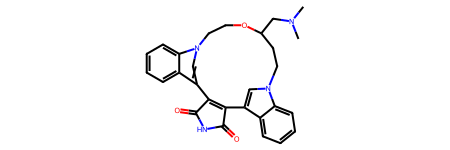

In [3]:
query = Chem.MolFromSmiles("CN(C)CC1CCN2C=C(C3=CC=CC=C32)C4=C(C5=CN(CCO1)C6=CC=CC=C65)C(=O)NC4=O") # SMILES of Ruboxistaurin
query

Luego generamos las huella dactilar de Morgan para la molécula de Ruboxistaurin

In [4]:
circular_fp_query = rdFingerprintGenerator.GetFPs([query])[0]
# See the fingerprint as a bit
circular_fp_query.ToBitString()

'000000000100000000000000000000000000000000010100000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000001000000000000000000000000000000000000000000000000000000100000000001000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000001010001000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000100000000000000000000000000000000000000000000001000000000000000000000000000000000000000000001000000001000000000000001000000000000000000000000000000000000000000000000

## Paso 3: Calcular las fingerprint del conjunto de datos
Ahora generamos las huellas dactilares de Morgan para todas las moléculas en nuestro conjunto de datos.

In [5]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = rdFingerprintGenerator.GetFPs(molecule_dataset["ROMol"].tolist())

## Paso 4: Calculamos la similitud entre la molécula y el conjunto de datos
Calculamos la similitud de Tanimoto entre la molécula Ruboxistaurin y todas las moléculas de nuestro conjunto de datos utilizando las huellas dactilares de Morgan

In [6]:
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)
molecule_dataset[["molecule_chembl_id", "tanimoto_morgan"]].head()

,molecule_chembl_id,tanimoto_morgan
0,CHEMBL2386094,0.305882
1,CHEMBL4084855,0.106383
2,CHEMBL3895998,0.138298
3,CHEMBL564450,0.362500
4,CHEMBL4077376,0.131868


Ahora podemos organizar los valores para identificar las moléculas más similares a la Ruboxistaurin

In [7]:
molecule_dataset.sort_values(by = ["tanimoto_morgan"], ascending=False, inplace=True)
molecule_dataset.head(5)

,molecule_chembl_id,smiles,ROMol,tanimoto_morgan
572,CHEMBL336179,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCn1...,<rdkit.Chem.rdchem.Mol object at 0x000002199D1...,0.603774
1079,CHEMBL131035,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCn1cc2c2c...,<rdkit.Chem.rdchem.Mol object at 0x000002199D1...,0.603774
1247,CHEMBL340259,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCn1cc2...,<rdkit.Chem.rdchem.Mol object at 0x000002199D2...,0.603774
786,CHEMBL130774,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCOC...,<rdkit.Chem.rdchem.Mol object at 0x000002199D1...,0.603774
175,CHEMBL321315,CN1CCCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)c2cn(c3cc...,<rdkit.Chem.rdchem.Mol object at 0x000002199D1...,0.593220


Finalmente, podemos ver la molécula Ruboxistaurin y las cinco moléculas más parecidas del conjunto de datos

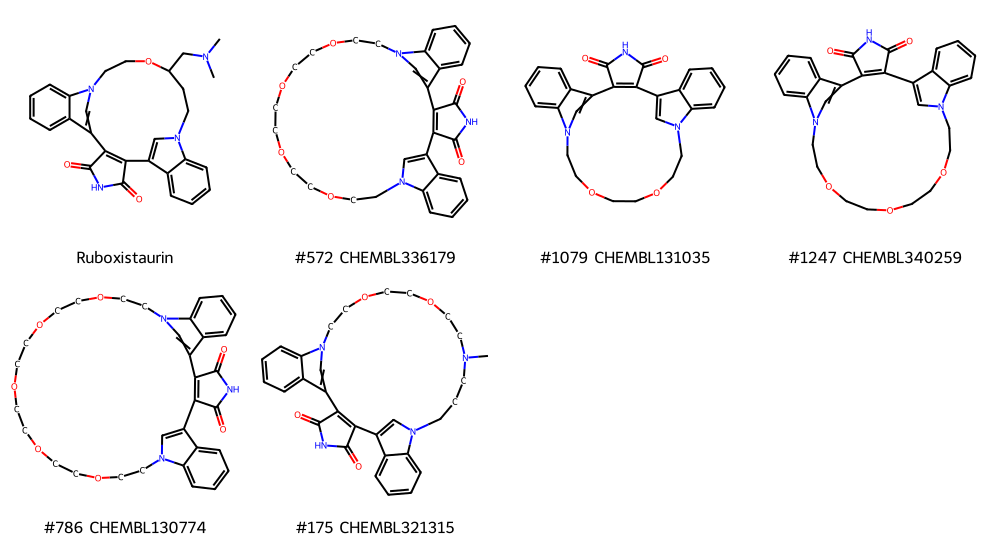

In [8]:
top_n_molecules = 5
top_molecules = molecule_dataset[:top_n_molecules]
legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in top_molecules.iterrows()
]
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Ruboxistaurin"] + legends),
    molsPerRow=4,
    subImgSize=(250, 270),
)

## Distribución de similitud
Para ver gráficamente la distribución de la similitud de Tanimoto, podemos hacer un histograma, recordemos que entre más cerca sea el número a 1, más similares son las moléculas.

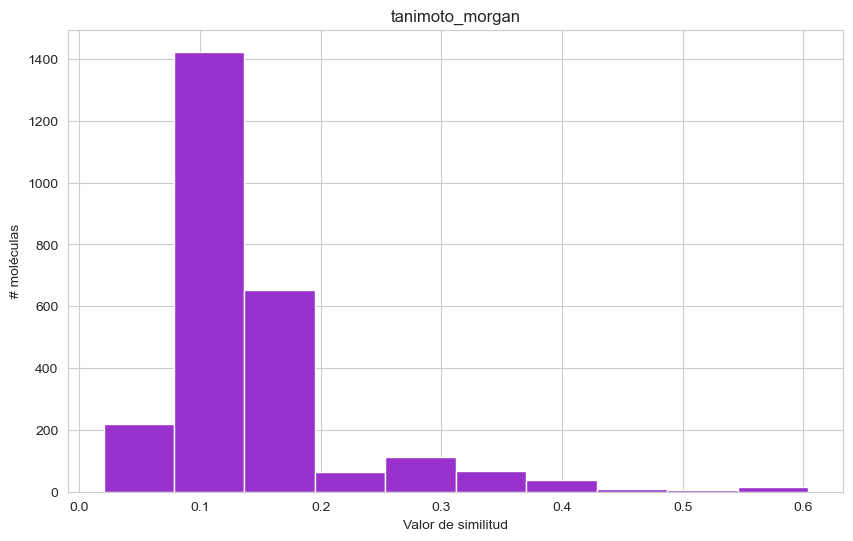

In [9]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=1) # Set up the matplotlib figure
molecule_dataset.hist(["tanimoto_morgan"], ax=axes, color = "darkorchid") # You can see more color name in the link https://www.w3schools.com/colors/colors_names.asp
axes.set_xlabel("Valor de similitud")
axes.set_ylabel("# moléculas")
fig;

También podemos hacer un histograma con una curva de estimaciones de densidad kernel usando seaborn. Con este gráfico, podemos ver la manera como se distribuye el conjunto de datos.

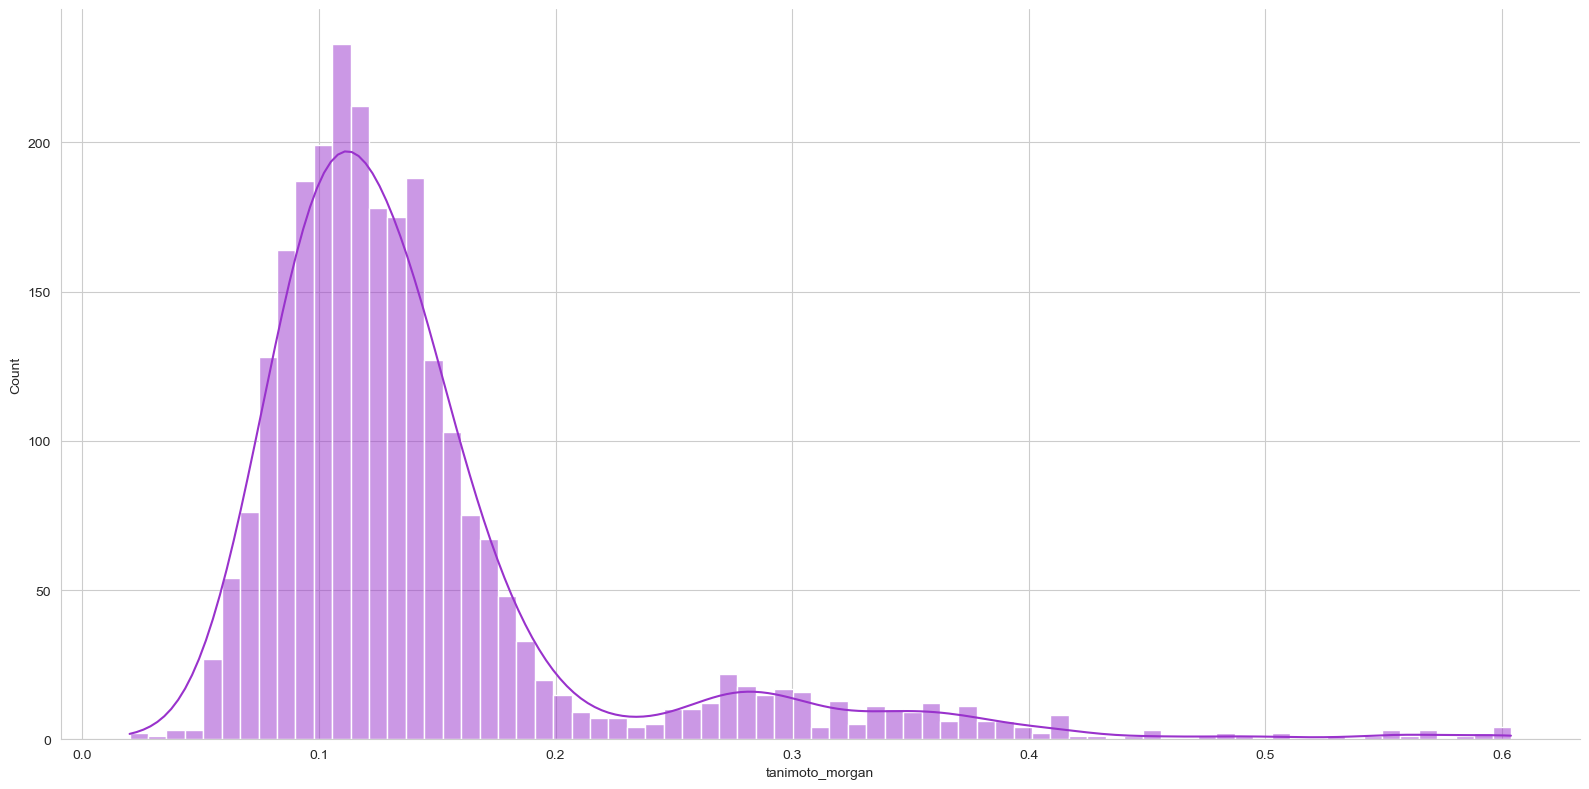

In [10]:
sns.displot(data=molecule_dataset["tanimoto_morgan"], kde=True, height=8, aspect=2, color="darkorchid")

# Ejemplo 2: Agrupación jerárquica (hierarchical clustering)
El agrupamiento jerárquico (**Hierarchical Clustering** en inglés), es un método comúnmente utilizado para agrupar datos con características similares (los grupos de datos se llaman **clústers**).

El algortimo de agrupamiento jerárquico agrupa los datos basándose en la distancia entre cada uno y buscando que los datos que están dentro de un clúster sean los más similares entre sí. Para nuestro caso, podemos agrupar los compuestos más similares de acuerdo a la distancia de Tanimonoto.

Inicialmente, vamos a utilizar el **agrupamiento tipo Aglomerativo** el cual inicia con cada compuesto como un clúster separado. A cada paso, los dos clústers más cercanos se fusionan creando un nuevo clúster. Estas fusiones se siguen produciendo de manera sucesiva hasta que al final del proceso solo queda un único clúster que aglomera todos los elementos.

Otro aspecto a tener en cuenta es la forma como se mide la **distancia** entre dos clústers, por definición se utiliza la * distancia euclidiana*, pero los algoritmos permiten modificar esta métrica.

## Preparación de datos

Iniciamos cargando el conjunto de datos que contiene los compuestos bioactivos contra la *glucógeno sintasa quinasa-3 beta* lo construimos en el tutorial 2.1_Dataframes.

A partir de los SMILES creamos los objetos *ROMol* y las *fingerprints* de cada compuesto

In [11]:
molecule_dataset = pd.read_csv('data/compounds_P49841_full.csv', usecols=["molecule_chembl_id", "smiles"])
print(f'# total de compuestos: {len(molecule_dataset)}')
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles") # add ROMol
morgan_fp_list = rdFingerprintGenerator.GetFPs(molecule_dataset["ROMol"].tolist()) # Morrgan FP
molecule_dataset['morgan_fp'] = morgan_fp_list
molecule_dataset.head()

# total de compuestos: 2605


,molecule_chembl_id,smiles,ROMol,morgan_fp
0,CHEMBL2386094,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,CHEMBL4084855,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3895998,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL564450,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,CHEMBL4077376,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Matriz de la similitud de Tanimoto
Similar a lo trabajado en el ejemplo 1, vamos a encontrar la similitud de cada molécula con el resto de moléculas del conjunto.

Vamos a crear una función cuya entrada es el conjunto de *fingerprints* de los compuestos, y cuya salida es la matriz de similitud de Tanimoto, donde se mide la similitud entre dos compuestos.

In [12]:
def tanimoto_matrix(fp_list):
    # Crear una matriz identidad
    N = len(fp_list)
    similarity_matrix = np.identity(N)
    # índices de las posiciones de la matriz triangular inferior
    a, b = np.tril_indices(N, 0)
    similarities = list()
    for ind, i in enumerate(fp_list):
        # Compare el fingerprint actual con todos los anteriores en la lista
        similarities = np.append(similarities, DataStructs.BulkTanimotoSimilarity(i, fp_list[:ind+1]))
        # Armar la matriz de distancia
    similarity_matrix[a,b] = similarities
    similarity_matrix[b,a] = similarity_matrix[a,b]
    return similarity_matrix

### Agrupamiento de diez moléculas
Para entender el proceso de agrupamiento vamos a trabajar solamente con las primeras diez moléculas del conjunto. Comenzamos creando una lista con los fingerprints de las diez moléculas.

In [13]:
lista_fingerprints = morgan_fp_list[0:10]

Ahora, encontramos la matriz de similitud de tanimoto con los diez fingerprints

In [14]:
similarity_matrix = tanimoto_matrix(lista_fingerprints) # Solo para los 10 primeros compuestos
similarity_matrix

array([[1.        , 0.09345794, 0.14285714, 0.28421053, 0.12621359,
        0.09174312, 0.55555556, 0.15533981, 0.09009009, 0.11538462],
       [0.09345794, 1.        , 0.17708333, 0.17346939, 0.67692308,
        0.83606557, 0.11214953, 0.16666667, 0.26666667, 0.17204301],
       [0.14285714, 0.17708333, 1.        , 0.10280374, 0.25842697,
        0.18556701, 0.18446602, 0.796875  , 0.67142857, 0.77777778],
       [0.28421053, 0.17346939, 0.10280374, 1.        , 0.14      ,
        0.18181818, 0.25252525, 0.11428571, 0.13333333, 0.10679612],
       [0.12621359, 0.67692308, 0.25842697, 0.14      , 1.        ,
        0.68181818, 0.13461538, 0.24719101, 0.18947368, 0.21348315],
       [0.09174312, 0.83606557, 0.18556701, 0.18181818, 0.68181818,
        1.        , 0.13084112, 0.17525773, 0.23404255, 0.18085106],
       [0.55555556, 0.11214953, 0.18446602, 0.25252525, 0.13461538,
        0.13084112, 1.        , 0.1980198 , 0.14953271, 0.18      ],
       [0.15533981, 0.16666667, 0.796875 

Podemos representarla por medio de un mapa de calor:

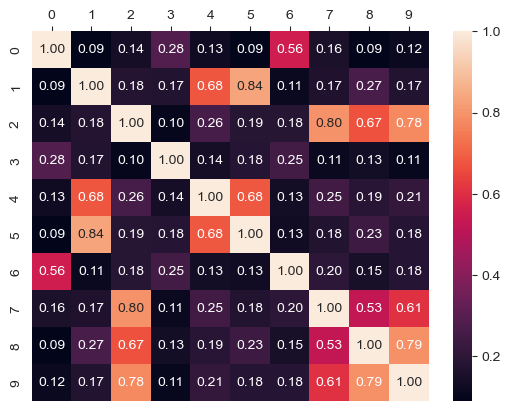

In [15]:
similarity_matrix = tanimoto_matrix(lista_fingerprints) # Solo para los 10 primeros compuestos
ax = sns.heatmap(similarity_matrix, annot=True, fmt='.2f') # annot= True imprime el coeficiente de Tanimoto y fmt='.2f' me da solo dos decimales 
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

#### Agrupamiento por distancias
Como lo explicamos inicialmente, el **agrupamiento por aglomeración** consiste en fusionar consecutivamente aquellos clústers que estén más cercados, para entender el agrupamiento podemos utilizar el método [`linkage`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage), el cual crea una *matriz de enlace* (linkage matrix) con el orden con el cual se agruparon los diferentes clústers (por defecto, la metrica de medida es la *distancia euclideana* y el método de agrupamiento es el *punto más cercano*).

In [16]:
Z = linkage(similarity_matrix)
Z

array([[ 1.        ,  5.        ,  0.23554759,  2.        ],
       [ 8.        ,  9.        ,  0.34334866,  2.        ],
       [ 2.        ,  7.        ,  0.36466205,  2.        ],
       [11.        , 12.        ,  0.38983764,  4.        ],
       [ 4.        , 10.        ,  0.49425813,  3.        ],
       [ 0.        ,  6.        ,  0.63974664,  2.        ],
       [ 3.        , 15.        ,  1.06605599,  3.        ],
       [14.        , 16.        ,  1.44150881,  6.        ],
       [13.        , 17.        ,  1.47784834, 10.        ]])

En la *i-ésima* fila, `Z[i,0]` y `Z[i,1]` indican los clusters que son combinaron para formar el clúster $n+i$. `Z[i,2]` indica la distancia entre los clústers y `Z[i,3]` representa el número de compuestos del nuevo clúster.
Recordemos que iniciamos con diez clústers enumerados del 0 al 9 (las diez moléculas iniciales), así, las filas de la matriz de enlace Z son:
- **fila-0**: Se crea el clúster 10 conformado por la molécula 1 (clúster 1) y la mólecula 5 (clúster 5), la distancia entre el clúster 1 y 5 es de 0.037348, y el nuevo clúster tiene 2 moléculas
- **fila-1**: Se crea el clúster 11 conformado por la molécula 8 (clúster 8) y la mólecula 9 (clúster 9), la distancia entre el clúster 8 y 9 es de 0.114080, y el nuevo clúster tiene 2 moléculas
- **fila-2**: Se crea el clúster 12 conformado por la molécula 2 (clúster 2) y el clúster 11 (creado en la fila-0), la distancia entre el clúster 2 y 11 es de 0.1713332, y el nuevo clúster tiene 3 moléculas
- **fila-3**: COMPLETAR
- **fila-4**: Se crea el clúster 14 conformado por la molécula 4 (clúster 4) y la mólecula 10 (clúster 10), la distancia entre el clúster 4 y 10 es de 0.224091, y el nuevo clúster tiene 3 moléculas
- **fila-5**: COMPLETAR
- **fila-6**: Se crea el clúuster 16 conformado por la molécula 3 (clúster 3) y el clúster 15 (creado en la fila-5), la distancia entre el clúster 3 y 15 es de 0.413761, y el nuevo clúster tiene 3 moléculas
- **fila-7**: COMPLETAR
- **fila-8**: Se crea el clúster 18 conformado por el clúster 16 (creado en la fila-6) y el clúster 17 (creado en la fila-17), la distancia entre el clúster 16 y 17 es de 1.660754, y el nuevo clúster tiene 10 moléculas

#### Representación: el *dendograma*
La manera de representar un agrupamiento jerárquico es con un dendrograma

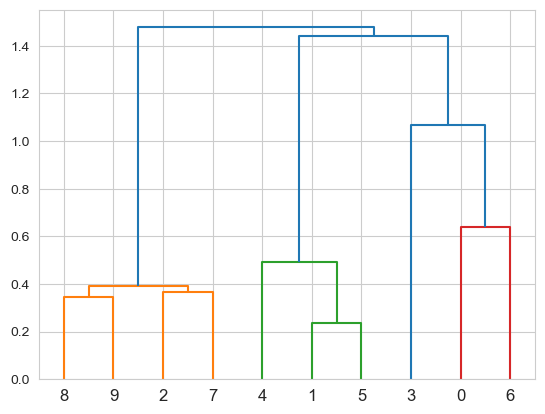

In [17]:
dn = dendrogram(Z)

Las líneas verticales del dendrograma ilustran las fusiones (o divisiones) realizadas en cada etapa del agrupamiento. Podemos ver la distancia, los distintos niveles de asociaciones entre los datos individuales y también las asociaciones entre clústers. Recordemos que la distancia utilizada fue la euclidiana, la cual podemos modificar cuando armamos Z.

#### Clustermap
Todo lo anterior se puede organizar en una matriz y graficar por medio de un mapa de calor de agrupamiento jerárquico, note que el orden de los compuestos no necesariamente es el mismo que el del dendograma

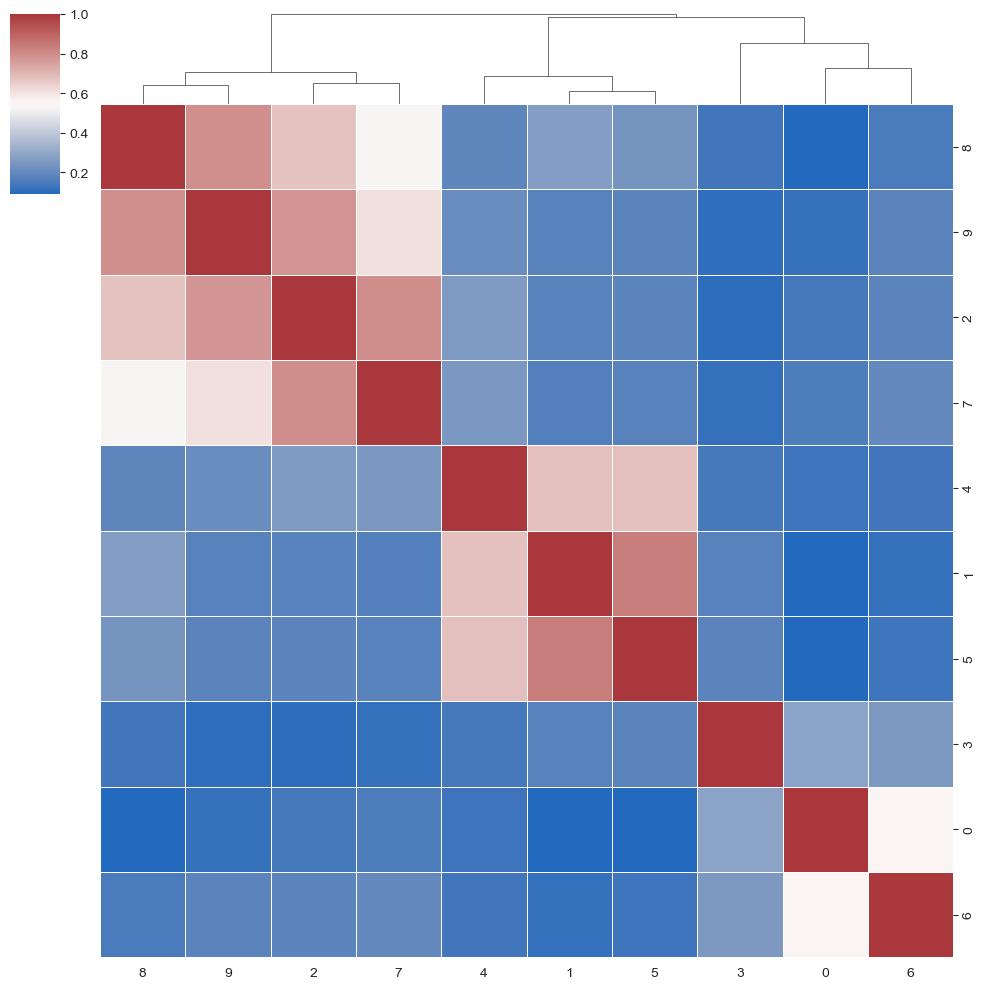

In [42]:
g = sns.clustermap(similarity_matrix, cmap="vlag",
                   dendrogram_ratio=(.1,.1),
                   linewidths=.5)
g.ax_row_dendrogram.remove()

#### Umbral de agrupamiento
Podemos utilizar la distancia entre los clústers como límite para agrupar los compuestos, por ejemplo, si elegimos agrupar clústers cuya distancia es menor o igual que 0.3, se formarían 5 con los siguientes compuestos:
- clúster-1: 0
- clúster-2: 6
- clúster-3: 3
- clúster-4: (2, 7 8, 9)
- clúster-5: (1, 4, 5)
El método ['fcluster'](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster) organiza un arreglo de $n$ elementos, donde cada elemento indica número del clúster al que pertenece el compuesto de esa posición

In [19]:
Z = linkage(similarity_matrix)
fcluster(Z, t=0.3, criterion='distance')

array([7, 5, 3, 9, 6, 5, 8, 4, 1, 2], dtype=int32)

### Algoritmo de agrupamiento *Butina*: Centroides y esferas de exclusión
Un algoritmo utilizado comunmente para agrupar moléculas es el conocido como el *algortimo de agrupamiento Butina* (Butina clustering algorithm) publicado en: Butina JCICS 39 747-750 (1999)

Podemos utilizar la librería `rdkit` para implementar este algorítmo (`Butina.ClusterData`). Como entrada se necesita una lista con las distancias de Tanimoto de los compuestos. Esta lista la podemos encontrar a partir de la matriz de similitud de Tanimoto donde las distancias se pueden hallar con la fórmula $distancia = 1 - similitud$.

Para armar la lista podemos utilizar la función de la matriz de tanimoto, separar solamente los elementos que están debajo de la diagonal principal y hallar la distancia

In [20]:
similarity_matrix = tanimoto_matrix(lista_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(lista_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b]  # distancias de los compuestos

Ahora escogemos un umbral de distancia para realizar el agrupamiento, por ejemplo, si escogemos como umbral 0.33, se obtienen cinco clústers.

In [21]:
clusters = Butina.ClusterData(dist_similarity_matrix,len(lista_fingerprints), 0.33, isDistData=True)
clusters = sorted(clusters, key=len, reverse=True)
clusters

[(2, 7, 8, 9), (5, 1, 4), (6,), (3,), (0,)]

**Observación**: Aunque el agrupamiento es similar al encontrado con el método `fcluster` note que el umbral utilizado es diferente, adicionalmente, el algoritmo de `Butina` determina el *centroide* del clúster, el cual será similar a cualquier otra molécula del clúster de acuerdo al valor del umbral dado. El primer elemento de cada clúster es el centroide.
(SUGIERO EXPLICAR MEJOR ESTA PARTE, PUEDEN LEER EL ARTICULO)

## Agrupamiento jeráquico de todo el conjunto de datos
Podemos utilizar lo aprendido con el agrupamiento de diez compuestos para representar el agrupamiento de todo el conjunto de compuestos.

Iniciemos encontrando la matriz de similitud de Tanimoto, como el total de compuestos es 2605, esta matriz tiene un tamaño de 2605 x 2605

**Observación**: la variable *circular_fp_list* tiene la lista de todas las fingerprints de los compuestos

In [22]:
similarity_matrix_full = tanimoto_matrix(circular_fp_list)
similarity_matrix_full.shape

(2605, 2605)

Mapa de calor de la matriz de similitud

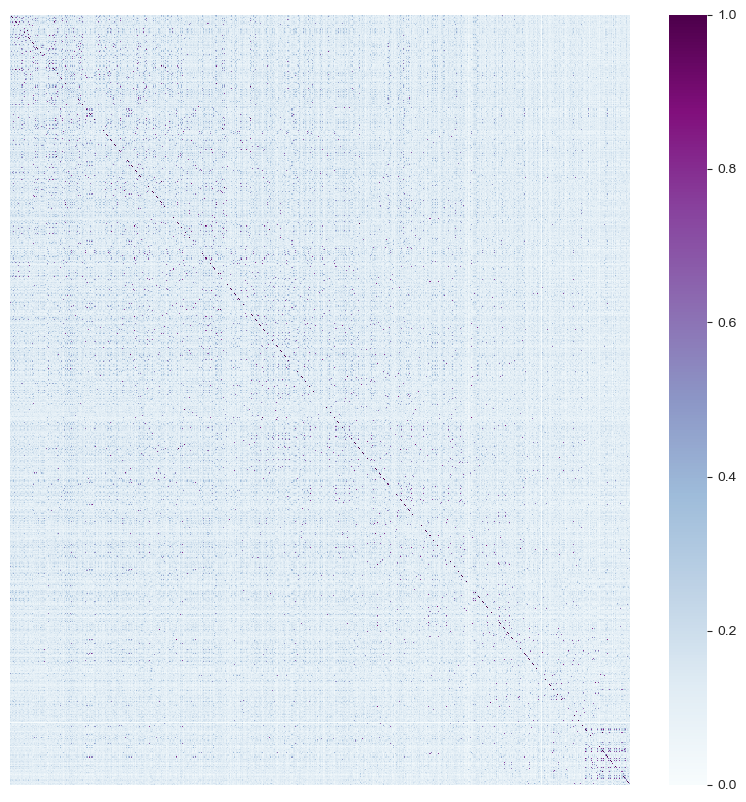

In [48]:

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(similarity_matrix_full, cmap="BuPu",
                 yticklabels=False,xticklabels=False)

### Agrupación: Algoritmo de agrupamiento Butina
Similar a la agrupación de los diez compuestos, vamos a crear una función en donde podemos decidir el umbral de la distancia de Tanimoto

In [24]:
def cluster_fingerprints(fp_list, cutoff=0.2):
    # Calcular la matriz similitud de Tanimoto
    similarity_matrix = tanimoto_matrix(fp_list)  # Matriz de similitud
    # econtrar la distancias entre los compuestos, guardar los datos como una lusta
    a, b = np.tril_indices(len(fp_list), -1)
    dist_similarity_matrix = 1 - similarity_matrix[a, b]
    # Ahora agrupar los datos con el algoritmo Butina:
    clusters = Butina.ClusterData(dist_similarity_matrix, len(fp_list), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [25]:
# Ejecutar el procedimiento de agrupación para el conjunto de datos, distancia: 0.1
clusters = cluster_fingerprints(morgan_fp_list, cutoff=0.2)
# Clústers más grandes
print(clusters[:10])

[(1067, 523, 689, 705, 713, 717, 821, 822, 825, 877, 1021, 1069, 1148, 1281), (1544, 1180, 1718, 1834, 1860, 1957, 1970, 2067, 2147, 2267, 2341), (642, 175, 233, 278, 572, 719, 786, 867, 1007, 1079, 1247), (2493, 2418, 2420, 2431, 2437, 2443, 2471, 2485, 2517, 2521), (426, 210, 249, 400, 571, 704, 734, 762, 819, 968), (1340, 971, 1049, 1134, 1143, 1195, 1258, 1286, 1323), (998, 559, 741, 853, 870, 876, 884, 917, 973), (573, 66, 72, 89, 118, 158, 268, 292, 299), (467, 174, 205, 242, 306, 310, 511, 539, 687), (165, 1, 21, 71, 82, 127, 166, 414, 558)]


Como estamos trabando con un conjunto grande de datos, no es buena idea imprimir las listas de los clústers, podemos resumir la información en una tabla de frecuencias.

In [26]:
agrup = list(map(len, clusters))
unique, counts = np.unique(agrup, return_counts=True)
frec_table = np.flip(np.array([unique, counts]).T) # reversed order
frec_table

array([[   1,   14],
       [   2,   11],
       [   2,   10],
       [   6,    9],
       [   5,    8],
       [   6,    7],
       [  12,    6],
       [  18,    5],
       [  33,    4],
       [  75,    3],
       [ 200,    2],
       [1494,    1]], dtype=int64)

Podemos ver que el clúster más grande (el primero) tiene 14 elementos y que hay 1494 compuestos que no se agruparon (clústers individuales)
Veamos gráficamente la cantidad de elementos en los clústers de mayor tamaño y cuántos hay de cada uno

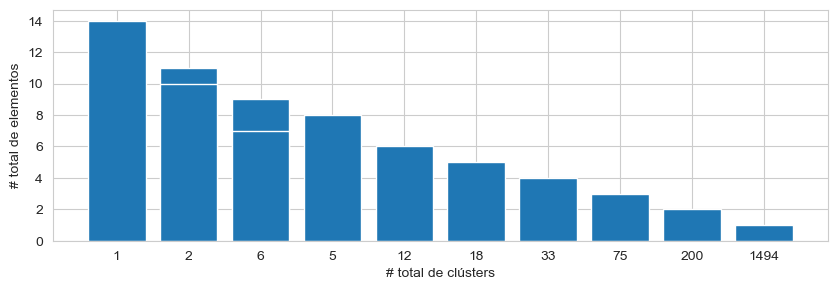

In [27]:
fig, ax = plt.subplots(figsize=(10, 3))  # Configurar la figura de matplotlib
ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1])
ax.set_xlabel("# total de clústers")
ax.set_ylabel("# total de elementos")
plt.show()
plt.close()

In [28]:
list_ind_cluster0 = list(clusters[0])
molecules_cluster0 = molecule_dataset.iloc[list_ind_cluster0]
molecules_cluster0

,molecule_chembl_id,smiles,ROMol,morgan_fp
1067,CHEMBL4749678,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
523,CHEMBL4789145,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
689,CHEMBL4785004,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccc(OC...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
705,CHEMBL4749327,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
713,CHEMBL4756997,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCCCNc3c4c(nc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
717,CHEMBL4753347,NC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc35...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
821,CHEMBL4798419,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCCCCCCCNc3c4c(nc5...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
822,CHEMBL4800403,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCCCCCNc3c4c(nc5cc...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
825,CHEMBL4777788,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5cc(Cl)...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
877,CHEMBL4787169,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x00000219A1C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


14 moleculas del clúster de mayor tamaño


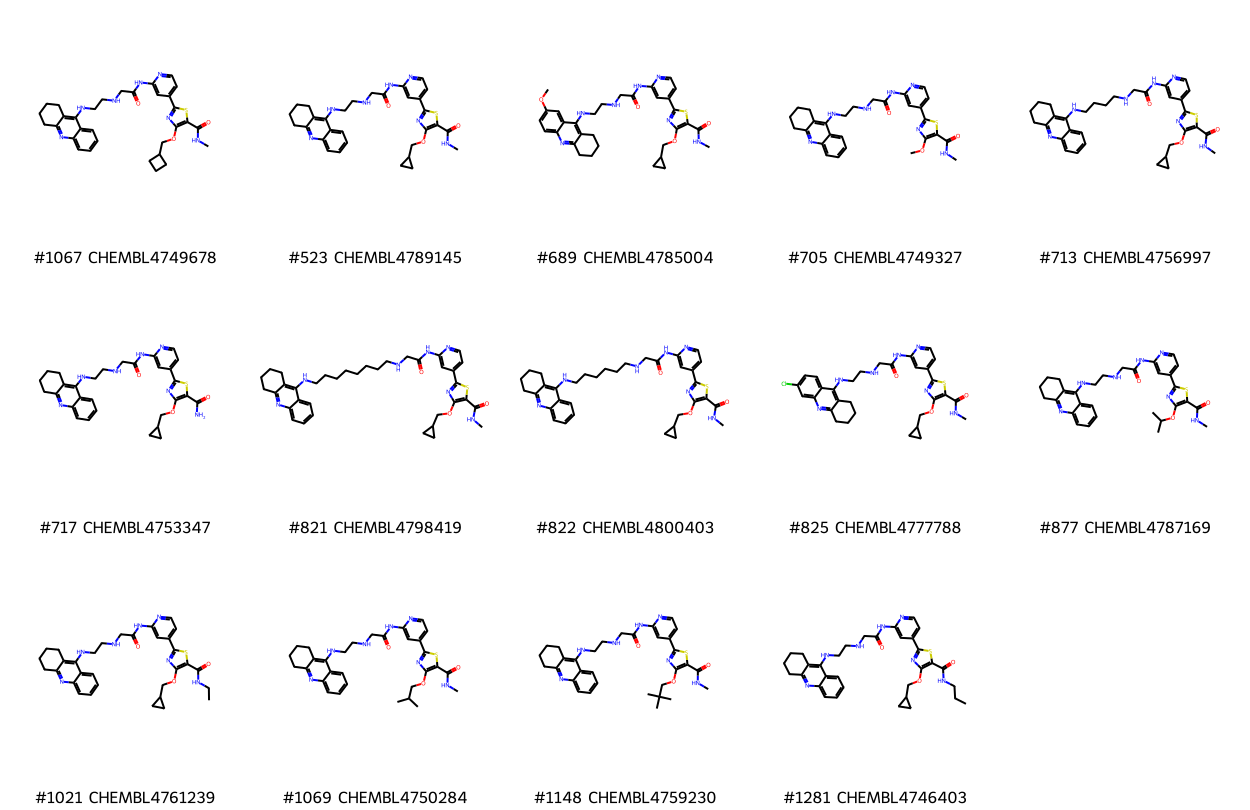

In [29]:
print(f'{len(molecules_cluster0)} moleculas del clúster de mayor tamaño')
legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in molecules_cluster0.iterrows()
]

Chem.Draw.MolsToGridImage(
    mols= molecules_cluster0["ROMol"].tolist(),
    legends=legends,
    molsPerRow=5,
    subImgSize=(250, 270),
)

También podemos tener un breve informe sobre el número de grupos y sus tamaños.

In [30]:
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g10 = sum(1 for c in clusters if len(c) > 10)

print("Número total de clústeres: ", len(clusters))
print("# clusters con solo 1 compuesto: ", num_clust_g1)
print("# clusters con >5 compuestos: ", num_clust_g5)
print("# clusters con >10 compuestos: ", num_clust_g10)


Número total de clústeres:  1854
# clusters con solo 1 compuesto:  1494
# clusters con >5 compuestos:  34
# clusters con >10 compuestos:  3


#### Modificando el umbral de la distancia de Tanimoto

También podemos trazar el tamaño de los grupos.

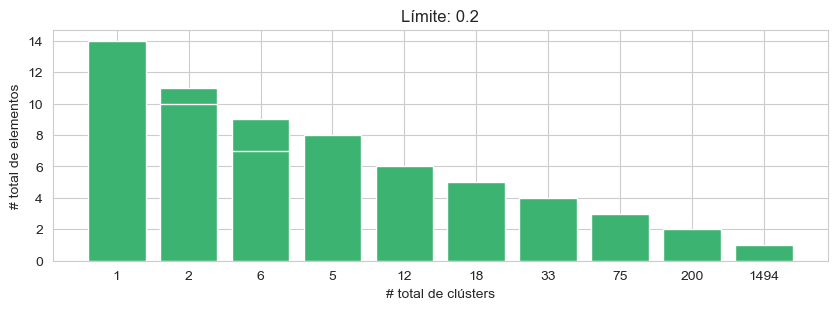

In [31]:
clusters = cluster_fingerprints(morgan_fp_list, cutoff=0.2)
fig, ax = plt.subplots(figsize=(10, 3)) # Configurar la figura de matplotlib
agrup = list(map(len, clusters))
unique, counts = np.unique(agrup, return_counts=True)
frec_table = np.flip(np.array([unique, counts]).T) # reversed order

ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1], color="mediumseagreen")
ax.set_title(f"Límite: 0.2")
ax.set_xlabel("# total de clústers")
ax.set_ylabel("# total de elementos")
plt.show()
plt.close()

Como vemos en la teoría, el resultado de la agrupación depende del umbral elegido, así que visualicemos diferentes puntos de corte.

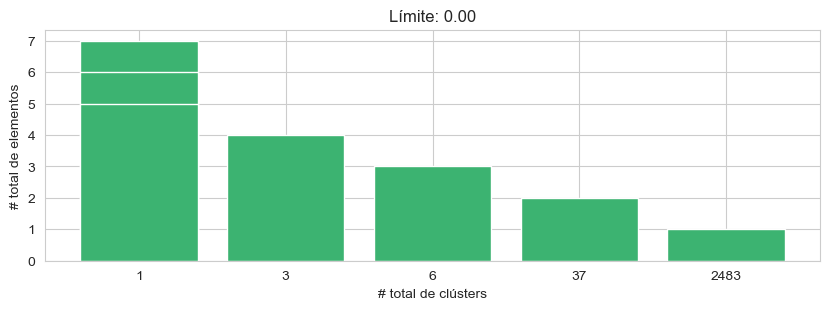

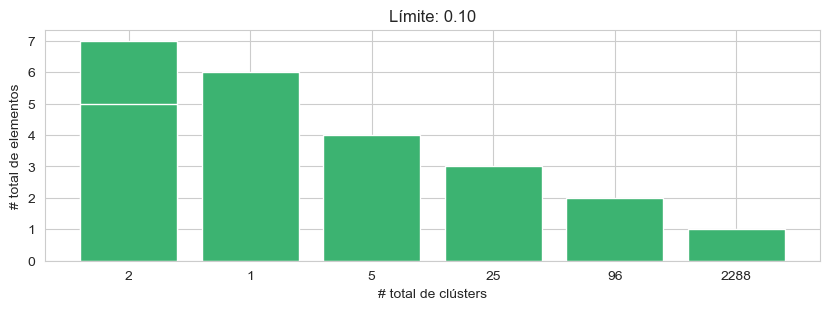

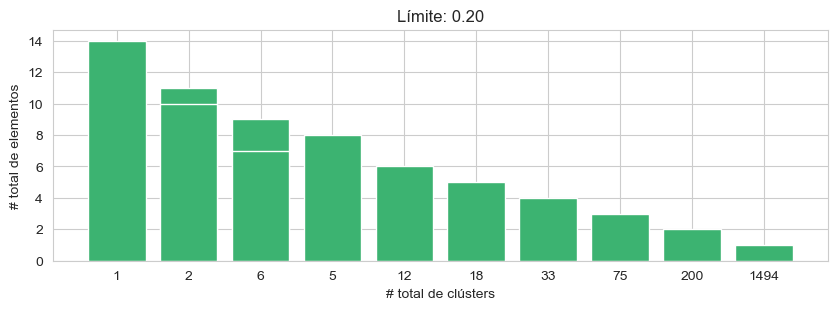

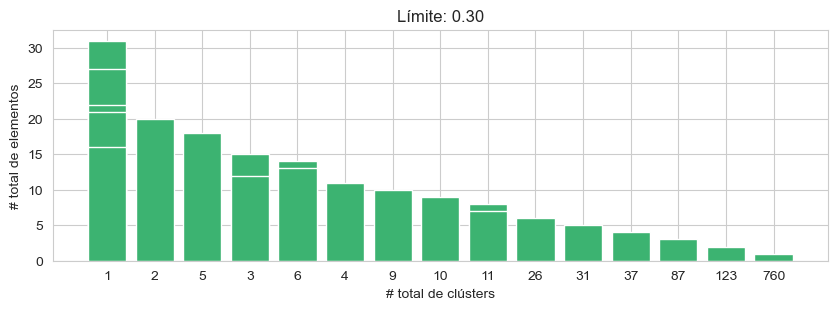

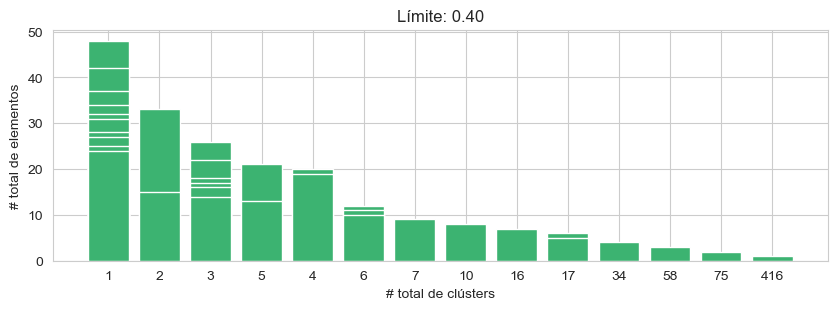

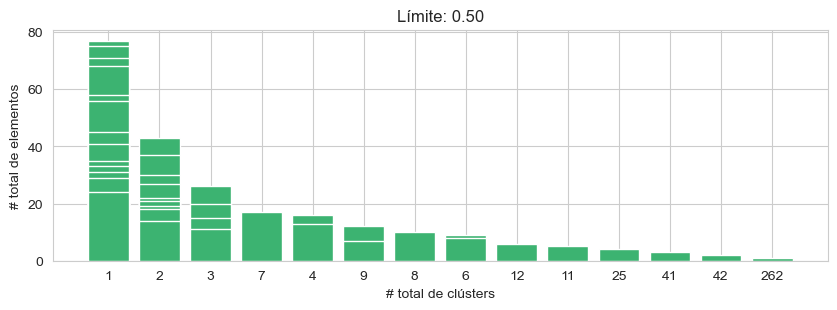

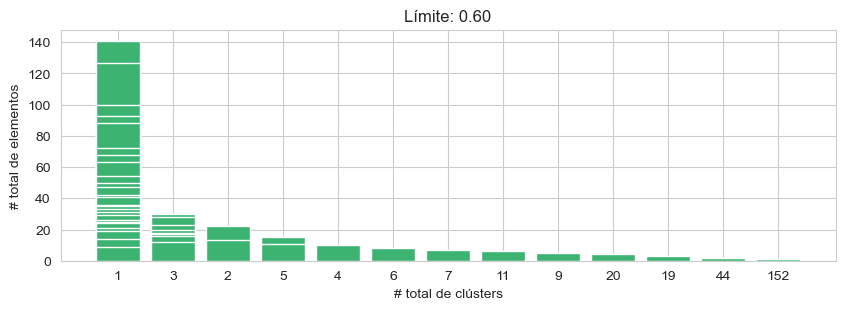

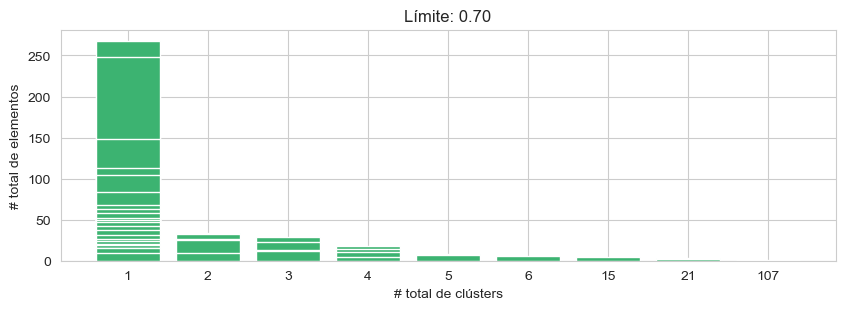

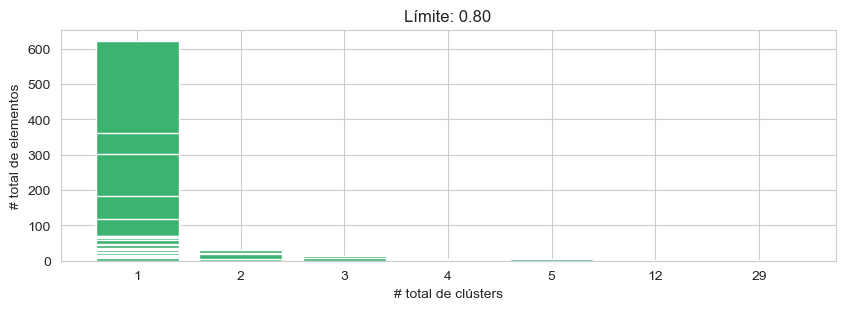

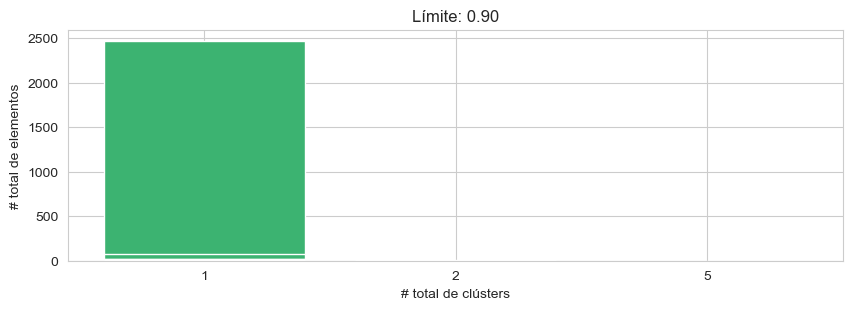

In [32]:
for cutoff in np.arange(0.0, 1.0, 0.1):
    clusters = cluster_fingerprints(morgan_fp_list, cutoff=cutoff)
    agrup = list(map(len, clusters))
    unique, counts = np.unique(agrup, return_counts=True)
    frec_table = np.flip(np.array([unique, counts]).T) # reversed order

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1], color="mediumseagreen")
    ax.set_title(f"Límite: {cutoff:.2f}")
    ax.set_xlabel("# total de clústers")
    ax.set_ylabel("# total de elementos")
    plt.show()
    plt.close()

## Clustermap
Podemos organizar la matriz de similitud de Tanimoto en un mapa de calor del agrupamiento jerárquico donde podemos ver cómo se agrupan las moléculas que mayor simlitud presentan

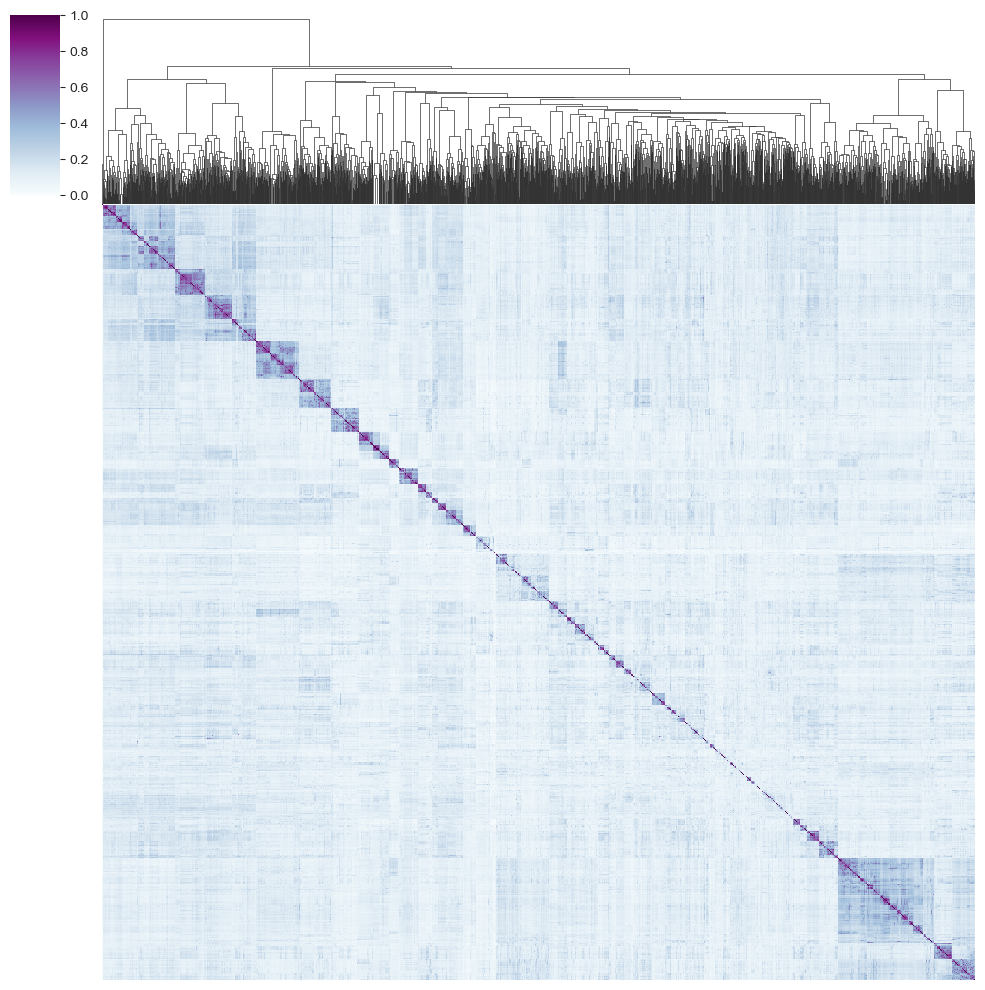

In [82]:
from matplotlib.pyplot import figure
similarity_matrix_full = tanimoto_matrix(circular_fp_list)

g = sns.clustermap(similarity_matrix_full, cmap="BuPu",
                   dendrogram_ratio=(.1,.2),
                   yticklabels=False,xticklabels=False,
                   figsize=(10,10))
g.ax_row_dendrogram.remove()
plt.savefig('./data/TanimotoSimilarity.png', bbox_inches='tight', dpi=500)
plt.show()
plt.close()

# Actividad práctica

Teniendo en cuenta lo aprendido en este Cuaderno, responde:
1. Visualiza diferentes puntos de corte con un intervalo de 0,1 entre cada
2. Seleccione un umbral diferente y apropiado y visualice los centros de los grupos de los primeros 10 grupos.

# Conclusión

En esta práctica, hemos aprendido cómo usar huellas dactilares y medidas de similitud para comparar una molécula de consulta con un conjunto de datos de moléculas y clasificar la molécula por similitud. Además, aprendimos sobre la agrupación en clústeres de un conjunto de datos compuesto y discutimos cómo elegir un umbral de agrupación razonable.